# Set up

## Import

In [1]:
#import
import numpy as np
import pandas as pd

import os
import glob
from rastertodataframe import raster_to_dataframe

from math import floor

from PIL import Image
import matplotlib.pyplot as plt

In [2]:
#custom functions

#function to create histogram of scenes class frequency
def nrcan_hist(img):
    import numpy as np
    import pandas as pd
    from collections import Counter

    im_array = np.array(img)

    #last line is bad values 
    im_array = im_array[:-1]

    #value count
    freq = Counter(im_array.flatten())

    plt.bar(freq.keys(), freq.values())
    plt.xlim([-1, 20])
    
#function to turn tiff to df
def tiff_to_df_colab(path):

    #Create folder path and list variables
    folder_path = path
    file_list = glob.glob(folder_path + "/*.tiff")

    #initiate empty dataframe
    main_dataframe = pd.DataFrame()

    for i in file_list:
        data = raster_to_dataframe(i)
  
        #extract name of band from file path
        band_info = str(i).split('/')[-1]
        band_name = band_info[-14:-11]
        #rename with band name
        data = data.rename(columns = {'Band_1': band_name})
        #merge into main dataframe
        main_dataframe = pd.concat([main_dataframe, data], axis = 1)

    return main_dataframe

## NRCan labels

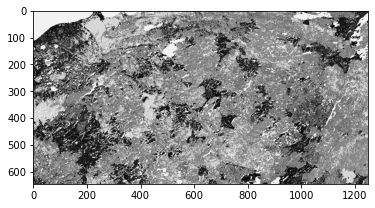

In [3]:
#import selected nrCAN extents
sask_nrcan = Image.open('../data_tests/scene_4/NRCAN_transformed.tif')
#show image
plt.imshow(sask_nrcan, cmap = 'gray', vmin = 0, vmax = 19)

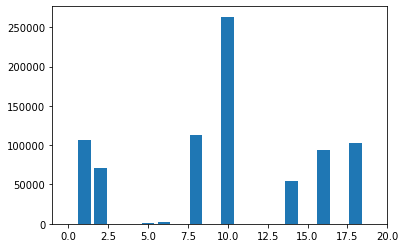

In [4]:
#class histogram plot
nrcan_hist(sask_nrcan)

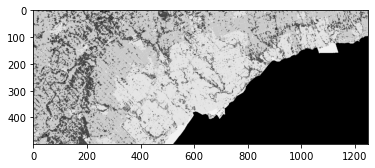

In [5]:
tor_nrcan = Image.open('../data_tests/scene_5/NRCAN_transformed.tif')
#show image
plt.imshow(tor_nrcan, cmap = 'gray', vmin = 0, vmax = 19)

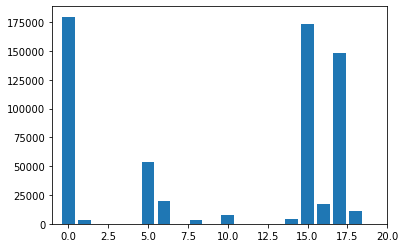

In [6]:
#class histogram plot
nrcan_hist(tor_nrcan)

## Raw bands

In [7]:
#load in raw bands
sask_raws = tiff_to_df_colab('../data_tests/scene_4/raws')
tor_raws = tiff_to_df_colab('../data_tests/scene_5/raws')
sim_raws = tiff_to_df_colab('../data_tests/simcoe_york/raws')
lab_raws = tiff_to_df_colab('../data_tests/labrador/raws')

sim_nrcan = raster_to_dataframe('../data_tests/simcoe_york/Simcoe_York_2019.tif')
lab_nrcan = raster_to_dataframe('../data_tests/labrador/NRCAN_transformed.tif')

tor_raws.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A
0,0.0934,0.1228,0.1588,0.2052,0.2344,0.2549,0.2729,0.2928,0.2947,0.3868,0.3853,0.2917
1,0.0890,0.1163,0.1507,0.1944,0.2210,0.2390,0.2560,0.2761,0.2777,0.3842,0.3827,0.2757
2,0.0893,0.1157,0.1511,0.1944,0.2199,0.2363,0.2552,0.2752,0.2764,0.3886,0.3842,0.2765
3,0.1104,0.1609,0.1919,0.2144,0.2526,0.2926,0.3128,0.3342,0.3254,0.3672,0.3320,0.3325
4,0.0723,0.0913,0.1220,0.1250,0.1730,0.2769,0.3134,0.3368,0.3366,0.3020,0.2353,0.3376


In [8]:
lab_raws.shape, lab_nrcan.shape

((2082500, 12), (2082500, 1))

In [9]:
#convert nrcan extents to 1 dimension array
sask_labels = np.asarray(sask_nrcan).reshape(len(sask_raws))
tor_labels = np.asarray(tor_nrcan).reshape(len(tor_raws))


#add label column
sask_raws['y'] = sask_labels
tor_raws['y'] = tor_labels
sim_raws['y'] = sim_nrcan
lab_raws['y'] = lab_nrcan

tor_raws.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A,y
0,0.0934,0.1228,0.1588,0.2052,0.2344,0.2549,0.2729,0.2928,0.2947,0.3868,0.3853,0.2917,15
1,0.0890,0.1163,0.1507,0.1944,0.2210,0.2390,0.2560,0.2761,0.2777,0.3842,0.3827,0.2757,15
2,0.0893,0.1157,0.1511,0.1944,0.2199,0.2363,0.2552,0.2752,0.2764,0.3886,0.3842,0.2765,15
3,0.1104,0.1609,0.1919,0.2144,0.2526,0.2926,0.3128,0.3342,0.3254,0.3672,0.3320,0.3325,15
4,0.0723,0.0913,0.1220,0.1250,0.1730,0.2769,0.3134,0.3368,0.3366,0.3020,0.2353,0.3376,15


# EDA

In [10]:
from itertools import product

In [11]:
def clean_raws(dataframe):
    clean_all = pd.DataFrame()

    #for each category
    for category in dataframe.y.unique():
        #initialize new dataframe using first band of current category
        clean_df = dataframe.loc[dataframe['y'] == category]['B01']

        #get quartile range
        Q1 = clean_df.quantile(0.25)
        Q3 = clean_df.quantile(0.75)
        outlier = Q3 * 2
        #delete values not within
        clean_df = clean_df[clean_df < outlier].reset_index()
    
        #for every subsequent band do the same thing and merge
        for band in dataframe.columns[1:-1]:
            temp_df = dataframe.loc[dataframe['y'] == category][band]
            
            Q1 = temp_df.quantile(0.25)
            Q3 = temp_df.quantile(0.75)
            outlier = Q3 * 2

            temp_df = temp_df[temp_df < outlier].reset_index()
            clean_df = clean_df.merge(temp_df, how= 'inner', on = 'index')
        
        clean_df['y'] = category    
        #append each cleaned category dataframe to dict
        clean_all = pd.concat([clean_all, clean_df])
    
    return clean_all.drop('index', axis = 1)

from osgeo.gdalconst import *
from osgeo import gdal
from scipy.ndimage import gaussian_filter

def gaussian_raws(path_to_dir,  sigma = 1, nrcan_name = 'NRCAN_transformed.tif'):
    raw_files = list(os.listdir(path_to_dir))
    
    gauss_df = pd.DataFrame()
    for i in raw_files:
        raw_img = gdal.Open(os.path.join(path_to_dir, i))
        rows = raw_img.RasterYSize
        cols = raw_img.RasterXSize
        
        raw_array = np.array(raw_img.ReadAsArray())
        
        raw_gauss = gaussian_filter(raw_array, sigma = sigma)
        
        raw_gauss = raw_gauss.flatten()
        gauss_df[i[-14:-11]] = raw_gauss
    
    nrcan = gdal.Open(os.path.join(path_to_dir, '..', nrcan_name))
    nrcan_array = np.array(nrcan.ReadAsArray())
    
    gauss_df['y'] = nrcan_array.flatten()
    return gauss_df

In [12]:
#in nrcan Nulls translate as 0
print((sask_raws.loc[sask_raws['y'] == 0]).empty) #none in sask extent
print((tor_raws.loc[tor_raws['y'] == 0]).empty) #there are in tor
print((lab_raws.loc[lab_raws['y'] == 0]).empty)

#in this case they all correspond to water
tor_raws['y'] = tor_raws['y'].replace({0:18})
lab_raws['y'] = lab_raws['y'].replace({0:18})
print((tor_raws.loc[tor_raws['y'] == 0]).empty) #all converted to water
print((lab_raws.loc[lab_raws['y'] == 0]).empty)


True
False
False
True
True


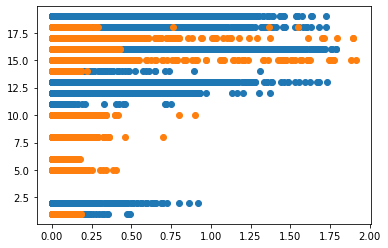

In [13]:
#comparing example band distribution within each class across two extents
plt.scatter(lab_raws['B01'], lab_raws.y)
plt.scatter(sim_raws['B01'], sim_raws.y)

In [14]:
#vertical concat
main_dataframe = pd.concat([sim_raws, lab_raws])
main_dataframe = main_dataframe.reset_index().drop('index', axis = 1)
#main_dataframe = lab_raws
#main_dataframe = clean_raws(main_dataframe)
                
sim_gauss = gaussian_raws('../data_tests/simcoe_york/raws', nrcan_name = 'Simcoe_York_2019.tif')
lab_gauss = gaussian_raws('../data_tests/labrador/raws')
main_dataframe = pd.concat([sim_gauss, lab_gauss])

In [15]:
stop

NameError: name 'stop' is not defined

In [ ]:
#class x every band

#number of axes = number of possible combos
fig, axes = plt.subplots(4, 3, figsize = (15, 40))

for i, ax in enumerate(axes.flat):
    
    #index of columns
    X_scatter = main_dataframe[main_dataframe.columns[:-1][i]]
    Y_scatter = main_dataframe['y']
    
    # scatter current combination
    ax.scatter(X_scatter, Y_scatter)
    ax.set_title(main_dataframe.columns[i])



In [16]:
print(main_dataframe.shape)
main_classes = main_dataframe.value_counts('y').sort_index() 
print(main_classes)

(7417500, 13)
y 
0         174
1      114942
2       20946
5      613360
6      378878
8       71198
10      18771
11     165380
12     526286
13     618139
14      93596
15    2836714
16     445947
17     512418
18     953631
19      47120
dtype: int64


In [17]:
#select classes above threshold
threshold = 18000
top_classes = main_classes[main_classes > threshold].reset_index().y

#save dataframe subset of those classes
main_subset = main_dataframe.loc[main_dataframe['y'].isin(top_classes.values)]

#take smallest value rounded down to nearest 1000
smallest_class = int(floor(min(main_subset.value_counts('y').sort_index().values)/ 1000)) * 1000
#subsampling - comment out for full set
smallest_class = threshold

#take subset of each class equal to smallest class value
data = main_subset.groupby("y").sample(n=smallest_class, random_state=24)
data.to_csv('data/testtrain.csv', index = False)

print(data.shape)
data.value_counts('y').sort_index()


(270000, 13)


y 
1     18000
2     18000
5     18000
6     18000
8     18000
10    18000
11    18000
12    18000
13    18000
14    18000
15    18000
16    18000
17    18000
18    18000
19    18000
dtype: int64

# Modelling

Random Forest, SVC, XGBoost [stretch] CNN

Iteration details:
- toronto, simcoe, sask, labrador = standard bands, no parameters, 5K each value, no scaling, in turn toronto, simcoe, sask, labrador extents only
- Base run = standard bands, no parameters, 5K each value, no scaling, sim and lab
- scaled = standard bands, no params, 5K each value, StandardScaler() -> improved SVC, sask and tor
- large set = standard bands, no parameters, 18K each value, no scaling, sim and lab
- gaussian = standard bands transformed via gaussian filter, 18K each value, no scaling, sim and lab
- demo = random forest applied to demo data
    - version_1 = 31.41% trained on sim & lab 18K each
    - version_2 =  31.55% trained on gaussian (sigma 5) sim & lab, 18K each -> overpredicts/performs well with 1, 5, 15 and 18
    - version_3 = 33.22% trained on gaussian (sigma 1) sim & lab, 18K each

Parameterization note: so far best results for RFC come from default with n_estimators = 300 with accuracy around 58.74 for source extent tests -> drops to 30 for demo test

To do:
- ensure all raws are aligned to a common 60 m res grid (downsampling all but b1 and b9)
- scaling sim & lab for svc -> if goes well svc parametrization
- basic NN?

## Import

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
from sklearn.decomposition import PCA

In [19]:
#set up save path for images
confusion_path = 'confusion_matrices/'
group_folder = 'base_run/'

## Processing

In [ ]:
#add bands
#Create NDVI column (B8-B4)/(B8+B4)
#data['NDVI'] = (data.B08-data.B04)/(data.B08+data.B04)
#Create Moisture index (B8A-B11)/(B8A+B11)
#data['Moisture'] = (data.B8A-data.B11)/(data.B8A+data.B11)
#Create NDWI (B3-B8)/(B3+B8)
#data['NDWI'] = (data.B03-data.B08)/(data.B03+data.B08)
#create NDSI (B3-B11)/(B3+B11)
#data['NDSI'] = (data.B03-data.B11)/(data.B03+data.B11)


#Ensure that all values are float32
#np.where(data.values >= np.finfo(np.float32).max)

In [37]:
y = data.y
X = data.drop('y', axis = 1)

#scaler = StandardScaler()
# = scaler.fit_transform(X)

#Dimensionality reduction
pca = PCA(n_components = 6)
pca.fit(X)
print(pca.explained_variance_ratio_)
X_pca = pca.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, train_size=0.8, random_state = 0)

[0.81364669 0.12740885 0.05468586 0.0017586  0.0011334  0.0008167 ]


In [ ]:
#drop outliers from train
train_data = pd.concat([X_train, y_train], axis = 1)

train_clean = clean_raws(train_data)
y_train = train_clean.y
X_train = train_clean.drop('y', axis = 1)

In [ ]:
train_clean.value_counts('y').sort_index()

In [ ]:
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

### SVC

In [ ]:
#Different SVC kernels - sig performed less then 1 percent on subsample so its removed
#linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_train, y_train)
#rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(X_train, y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(X_train, y_train)
#sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(X_train, y_train)

In [ ]:
#predict from X_test
#linear_pred = linear.predict(X_test)
poly_pred = poly.predict(X_test)
#rbf_pred = rbf.predict(X_test)
#sig_pred = sig.predict(X_test)

In [ ]:
# retrieve the accuracy and print it for all 4 kernel functions
#accuracy_lin = linear.score(X_test, y_test)
accuracy_poly = poly.score(X_test, y_test)
#accuracy_rbf = rbf.score(X_test, y_test)
#accuracy_sig = sig.score(X_test, y_test)

# creating a confusion matrix
#cm_lin = confusion_matrix(y_test, linear_pred)
cm_poly = confusion_matrix(y_test, poly_pred)
#cm_rbf = confusion_matrix(y_test, rbf_pred)
#cm_sig = confusion_matrix(y_test, sig_pred)

#visual confusion matrix
#cm_lin_fig = ConfusionMatrixDisplay(confusion_matrix = cm_lin, display_labels = linear.classes_)
cm_poly_fig = ConfusionMatrixDisplay(confusion_matrix = cm_poly, display_labels = poly.classes_)
#cm_rbf_fig = ConfusionMatrixDisplay(confusion_matrix = cm_rbf, display_labels = rbf.classes_)

#print accuracy and confusion matrix
#print(accuracy_lin)
#cm_lin_fig.plot()
print(accuracy_poly)
cm_poly_fig.plot()
#print(accuracy_rbf)
#cm_rbf_fig.plot()

In [ ]:
#save confusion matrices
cm_lin_fig.figure_.savefig(os.path.join(confusion_path, group_folder, 'lin.png'), dpi = 300)
cm_poly_fig.figure_.savefig(os.path.join(confusion_path, group_folder, 'poly.png'), dpi = 300)
cm_rbf_fig.figure_.savefig(os.path.join(confusion_path, group_folder, 'rbf.png'), dpi = 300)

### Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

0.6098333333333333


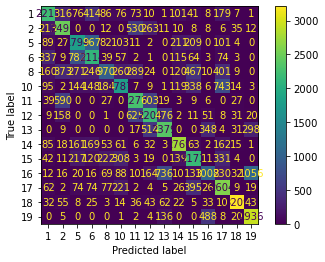

In [38]:
forest = RandomForestClassifier(random_state = 0,  n_estimators = 300, max_depth = 25, max_features = 2).fit(X_train, y_train)

#get accuracy
forest_pred = forest.predict(X_test)
print(accuracy_score(y_test, forest_pred))

#plot confusion matrix
cm_forest = confusion_matrix(y_test, forest_pred)
cm_forest_fig = ConfusionMatrixDisplay(confusion_matrix = cm_forest, display_labels = forest.classes_)
cm_forest_fig.plot()

In [ ]:
#band weight
forest.feature_importances_

In [ ]:
#save
cm_forest_fig.figure_.savefig(os.path.join(confusion_path, group_folder, 'forest.png'))
print(classification_report(y_test, forest_pred))

In [25]:
gauss_test = gaussian_raws('../data_tests/scene_5/raws')
gauss_test.head()

gauss_test['y'] = gauss_test['y'].replace({0:18})

[0.81364669 0.12740885 0.05468581 0.0017586  0.0011334  0.0008167 ]
0.5641955911823647


ValueError: The number of FixedLocator locations (13), usually from a call to set_ticks, does not match the number of ticklabels (15).

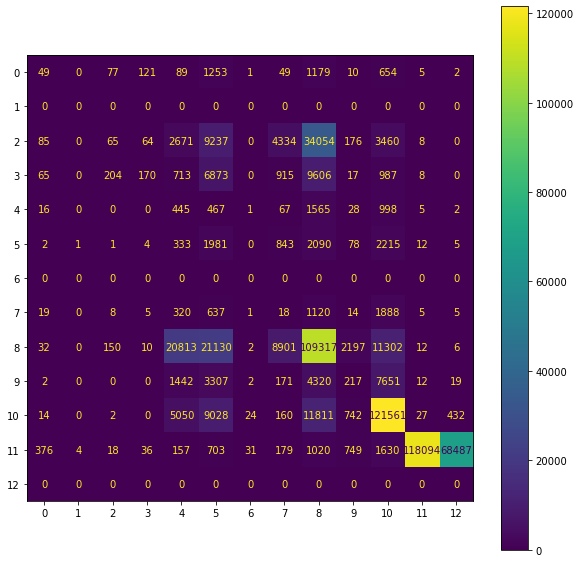

In [27]:
y_gauss = gauss_test.y
X_gauss = gauss_test.drop('y', axis = 1)

pca = PCA(n_components = 6)
pca.fit(X)
X_gauss_pca = pca.transform(X_gauss)

gauss_pred = forest.predict(X_gauss_pca)
print(accuracy_score(y_gauss, gauss_pred))

cm_forest = confusion_matrix(y_gauss, gauss_pred)
cm_forest_fig = ConfusionMatrixDisplay(confusion_matrix = cm_forest, display_labels = forest.classes_)
fig, ax = plt.subplots(figsize=(10,10))
cm_forest_fig.plot(ax = ax)

#### Demo test

In [34]:
#import demo test data
demo_raw = pd.read_csv('../data_tests/demo_site.csv')
demo_raw.land_cover = demo_raw.land_cover.astype('int')
demo_raw.head()

#test 2 - demo
y_demo = demo_raw.land_cover
X_demo = demo_raw.drop('land_cover', axis = 1)
print(X_demo.shape)

(5250000, 12)


In [ ]:
y_train.unique(), y_demo.unique()

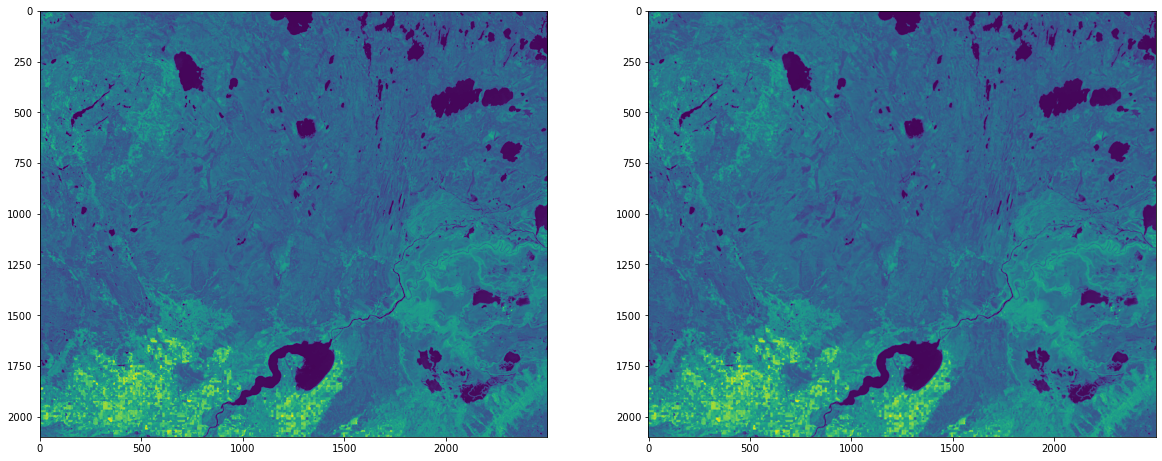

In [29]:
#convert into matrices to perform gaussian then convert back into 1d array and append to dataframe
X_demo_gauss = pd.DataFrame()
for band in X_demo.columns:
    #band = X_demo.columns[0]
    reconstruct = np.asarray(X_demo[band]).reshape(2500, 2100).T
    recon_gauss = gaussian_filter(reconstruct, sigma = 1)
    X_demo_gauss[band] = recon_gauss.flatten()
    
#compare demo input and gauss output
fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side

ax1.imshow(reconstruct)
ax2.imshow(recon_gauss)

0.33222438095238094


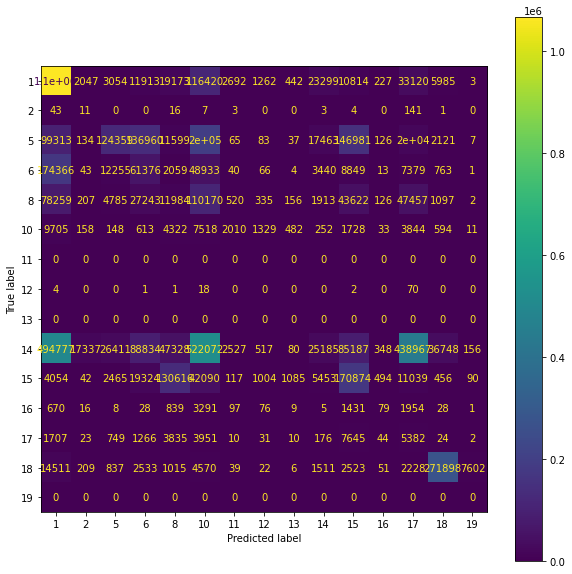

In [39]:
#generate predictions
demo_pred = forest.predict(X_demo)
#demo_pred = forest.predict(X_demo_gauss)

#accuracy
print(accuracy_score(y_demo, demo_pred))

#confusion matrix
cm_forest = confusion_matrix(y_demo, demo_pred)
cm_forest_fig = ConfusionMatrixDisplay(confusion_matrix = cm_forest, display_labels = forest.classes_)
fig, ax = plt.subplots(figsize=(10,10))
cm_forest_fig.plot(ax = ax)

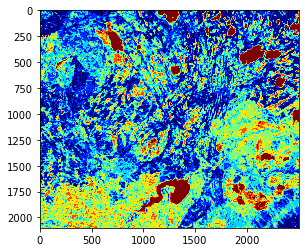

In [48]:
from matplotlib import cm

map_pred = np.asarray(demo_pred).reshape(2500, 2100).T
cmap = cm.get_cmap('jet', 7)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=cmap)

In [54]:
#save
cm_forest_fig.figure_.savefig(os.path.join(confusion_path, 'demo', 'version_3.png'))

#prediction map
prediction_map.figure.savefig(os.path.join(confusion_path, 'demo', 'map_3.png'))

### XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
xg_classes = list(range(len(y_train.unique())))

xg_y_train = y_train.replace(y_train.unique(), xg_classes)
xg_y_test = y_test.replace(y_test.unique(), xg_classes)

In [ ]:
xg_cl = xgb.XGBClassifier().fit(X_train, xg_y_train)

#get accuracy
accuracy_xgb = xg_cl.score(X_test, xg_y_test)
print(accuracy_xgb)

#plot confusion matrix
xgb_pred = xg_cl.predict(X_test)
cm_xgb = confusion_matrix(xg_y_test, xgb_pred)
cm_xgb_fig = ConfusionMatrixDisplay(cm_xgb)
cm_xgb_fig.plot()

In [ ]:
#save
cm_xgb_fig.figure_.savefig(os.path.join(confusion_path, group_folder, 'xgb.png'), dpi = 300)